In [2]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [3]:
# some helper functions
def compute_concord(t1,t2):
    '''Compute the concordance matrix'''
    n1 = np.size(t1)
    n2 = np.size(t2)
    
    t1 = np.reshape(t1,[n1,1])
    t2 = np.reshape(t2,[1,n2])
    # indicator function here
    C = np.array((t1-t2)>0,dtype=np.int)
    
    return C

def random_pairs(SX, ST, M):

    POS = list()
    NEG = list()
    POS_tt = list()
    NEG_tt = list()
    # random select M pairs in training to learn the conditional distribution of p(g(ii)>g(jj)|ii,jj)
    # with g(x) = x'beta+epsilon 
    for k in range(M):
        ii = 0
        jj = 0
        while ii==jj:
            # random find a pair each iteration
            ii = np.random.randint(n)
            jj = np.random.randint(n)
        # SFX: sorted FX
        # random selected pair from SFX
        xy = [SX[ii,0],SX[jj,0]]
        tt = [ST[ii,0], ST[jj,0]]
        # ST: sorted event time
        # with the same pair of index, if predicted x > predicted y
        # it's a positive pair
        if ST[ii,0]>ST[jj,0]:
            POS.append(xy)
            POS_tt.append(tt)
        else:
            #  otherwise when predicted x <= predicted y, it's a negative pare
            NEG.append(xy)
            NEG_tt.append(tt)
    POS = np.array(POS)
    NEG = np.array(NEG)

    X = np.concatenate((POS,NEG),axis=0)
    tt = np.concatenate((POS_tt,NEG_tt),axis=0)
    y = np.zeros([M,])


    nb_pos = np.shape(POS)[0]
    # label y as 1(POS),0(NEG)
    y[:nb_pos] = 1

    perm_idx = np.random.permutation(M)
    X = X[perm_idx,:]
    y = y[perm_idx]
    tt = tt[perm_idx]
    
    return(X,y,tt)

def sort_dataset(dataset):
    sidx = np.argsort(dataset['T'],axis=0)
    dataset['sorted_x'] = dataset['x'][sidx,:] # sorted predictor
    dataset['sorted_t'] = dataset['T'][sidx]   # sorted event time (wrt predictor)
    dataset['sorted_e'] = np.ones(len(sidx))   # sorted event time (wrt predictor)
    return (dataset)

def calculate_quantiles(post_prob, tt, percentiles):
    post_prob_sum = np.cumsum(post_prob)
    try:
        tt_p = [tt[np.argmin(np.abs(post_prob_sum-p))] for p in percentiles]
    except TypeError:
        tt_p = tt[np.argmin(np.abs(post_prob_sum-percentiles))]
        tt_p = [tt_p]
        
    return(np.array(tt_p))



In [4]:
def single_patient_true_dist_cox_gompertz(covariates, lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    beta_linear = np.array([0.15,0.001])
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    
    U = np.random.uniform(size=n)
    # generate T accordingly
    T = (1/alpha_)*np.log(1-alpha_*np.log(U)/(lambda_*np.exp((np.dot(X,beta_linear)))))
    # generate labels (censoring or event)
    np.random.seed(seed)
    T_dist = 1-np.exp((lambda_/alpha_)*(1-np.exp(alpha_*tt)))
    
    return({"T": T, 'T_dist':T_dist})

def single_patient_true_dist_cox_gompertz_nonlinear(covariates, lambda_=7e-8, alpha_=0.2138, n=1000,seed=123):
    beta_linear = np.array([0.15,0.001])
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = np.array(X_cts)
    
    U = np.random.uniform(size=n)
    # generate T accordingly
    T = (1/alpha_)*np.log(1-alpha_*np.log(U)/(lambda_*np.exp((np.dot(X,beta_linear))**3)))
    # generate labels (censoring or event)
    np.random.seed(seed)
    
    return({"T": T})

In [5]:
a = np.ones(6).reshape(2,3)
std = np.std(a,axis=0)
std[std==0] = np.mean(a,axis=0)+1e-3
std

array([1.001, 1.001, 1.001])

In [6]:
from torch.utils.data import Dataset, DataLoader, Sampler
class SimpleDataset(Dataset):
    def __init__(self, x, y, e, transform=False, covlist = None, mean=0, std = 1):
        self.data = x
        self.targets = y
        self.label = e
        self.transform = transform
        self.covlist = covlist
        if not self.covlist:
            self.covlist = np.arange(self.data.shape[1])
        
        if self.transform:
            self.mean, self.std = mean, std
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        if self.transform:
            return (img[self.covlist]-self.mean)/self.std, target, label
        else:
            return img, target, label
        
        

    def __len__(self):
        return len(self.data)
    
#     def get_mean_std(self):            
#         mean = np.mean(self.data[:,self.covlist], axis = 0)
#         std = np.std(self.data[:,self.covlist], axis = 0)
# #         print(std)
#         # set covariates with std =0 has std = mean
#         std[std==0] = mean[std==0]+1e-3

#         return mean, std

## Cox-gompertz linear setting

In [7]:
n = 10000
# first consider only 1 covariate
def simulation_cox_gompertz(n=10000, p=2, pc=0, pc_level=4, pval=[1/4.]*4, lambda_=7e-8, alpha_=0.2138, censor_bound= 68,seed=123):
    # linear relationship
    # n: number of patients
    # p: number of total covariates
    # pc: number of categorical variables
    # pc_level: levels of categorical variable
    # pval: probabilities for each level
    # lambda_exp: parameters for baseline hazards
    # censor_bound: upper bound of censoring generating process
    p_total = (p-pc) + pc*pc_level
    np.random.seed(seed)
    if p-pc == 2:
        # generate based on Bender's paper
        beta_linear = np.array([0.15,0.001])
        X_age = np.random.normal(loc=24.3, scale = 8.38, size=n).reshape((n,1))
        X_randon = np.random.normal(loc=266.84, scale = 507.82, size=n).reshape((n,1))
        X_cts = np.concatenate((X_age, X_randon), axis=1)
    else:
        beta_linear = np.random.normal(0,1,p_total)
        X_cts = [np.random.normal(loc=0, scale=1.0, size=n) for i in range(p-pc)]
        X_cts = np.transpose(np.stack(X_cts, axis=0 ))

    if (pc>0):
        X_cat = [np.random.multinomial(1, pval, size=n) for i in range(pc)]
        X_cat = np.stack(X_cat, axis=0 ).reshape(n,pc_level*pc)
        one_hot_indices = [[i,i+1,i+2,i+3] for i in np.arange(p-pc,p_total, pc_level)]    
        X = np.concatenate((X_cts, X_cat), axis=1)
    else:
        X = X_cts
        one_hot_indices = []
        
    # the problem with the left tail is about this U!
    U = np.random.uniform(size=n)
    # generate T accordingly
    T = (1/alpha_)*np.log(1-alpha_*np.log(U)/(lambda_*np.exp(np.dot(X,beta_linear))))
    sidx = np.argsort(T,axis=0)
    TS = T[sidx]
    XS = X[sidx,:]
    np.random.seed(seed)
    # change the way censoring is defined
    # first set the maximum censoring at: censor_bound
#    C = np.repeat(censor_bound,n)
    right_truncate = T<censor_bound
    EPS = 0
    # define C only for the right truncated samples
    C = np.random.uniform(0+EPS,censor_bound,size=len(T[right_truncate]))
    CS = np.concatenate([C,np.repeat(censor_bound,n-len(T[right_truncate]))])
    event = 1*(TS<CS)
    nonevent = CS<TS
    # observed time
    YS = TS.copy()
    YS[nonevent] = CS[nonevent]
    
    # shuffle back to unsorted order
    perm_idx = np.random.permutation(n)
    X = XS[perm_idx,:]
    Y = YS[perm_idx]
    event = event[perm_idx]
    C = CS[perm_idx]
    T = TS[perm_idx]
    
    t = C*(C<T) +  T*(C>=T)
    return({"t": Y, "e":event, "x":X, "T": T,"C":C,'one_hot_indices':one_hot_indices})

# np.random.rand:  
# Create an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
# now X is uniform between [-3,3]
train = simulation_cox_gompertz(n=10000, seed=123)
test = simulation_cox_gompertz(n=5000, seed=124)

(2791,)


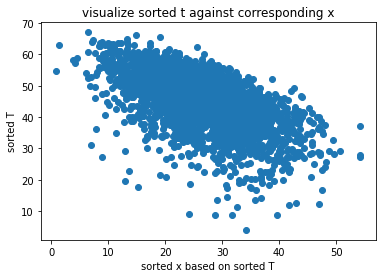

In [8]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
T = train['T']
# argsort gives the order of index based on the sorted value
e_idx = np.where(train['e']==1)[0]

n = len(T)

X_ = X[e_idx,:]
T_ = T[e_idx]
sidx = np.argsort(T_)

SX = X_[sidx,0] # sorted predictor
ST = T_[sidx]   # sorted event time (wrt predictor)
plt.plot(SX,ST,'o')
plt.xlabel("sorted x based on sorted T")
plt.ylabel("sorted T")
plt.title('visualize sorted t against corresponding x')
print(SX.shape)

## define MLP classifier 

In [9]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

### Discretize the timeline

In [10]:
# helper functions
# transform t into categories
# one-hot-encoding
# only consider the nearest category to the left
##### for re-formulate time #####
def t_tt_idx(t_,tt):
    t_diff = t_-tt
    t_diff_sign = (t_diff>=0)
    if len(t_diff[t_diff_sign])>0:
        idx = np.argmin(t_diff[t_diff_sign])
    else:
        idx = 0
    return idx


def t_label(t_,tt):
    nbin = len(tt)
    t_diff = t_-tt
    t_diff_sign = (t_diff>=0)
    if len(t_diff[t_diff_sign])>0:
        idx = np.argmin(t_diff[t_diff_sign])
        t_cat = np.zeros(nbin)
        t_cat[idx] = 1.0
    else:
        t_cat = np.zeros(nbin)
        t_cat[0] = 1.0
    return t_cat

def t_label_censor(t_, tt,):
    t_idx = t_tt_idx(t_,tt)
    t_prob = np.concatenate([np.zeros(t_idx), np.ones(len(tt)-t_idx)])
    return t_prob


def t_categorize(t_, e_, tt):
    if e_ == 1:
        t_cat = t_label(t_,tt)
    else:
        t_cat = t_label_censor(t_, tt)
    return t_cat
    
def batch_t_categorize(batch_t, batch_e, tt):
    nbin = len(tt)
    nbatch = batch_t.shape[0]
    all_cat = np.array([t_categorize(batch_t[obs], batch_e[obs], tt) for obs in np.arange(nbatch)])    
    return all_cat


In [12]:
nbin=100
# tt = np.percentile(train['t'][train['e']==1],np.linspace(0.,100.,nbin, endpoint=True))
tt = np.linspace(0.,np.max(train['t'][train['e']==1]),nbin, endpoint=True)

# based on whether we have censoring after the largest observed t
loss_of_info = np.mean(train['t']>np.max(train['t'][train['e']==1]))

# need to convert t to different size of bins
if loss_of_info > 0.0001:
    nbin = nbin + 1
    # add the largest observed censoring time inside
    tt = np.append(tt,np.max(train['t']))
#     event_tt_prob = risk_t_bin_prob(train['t'], train['e'], tt)
t_max = np.max(train['t'][train['e']==1])
t_all_max = np.max(train['t'])
t_all_max, t_max

(68.0, 67.08394243060246)

In [13]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
t = train['t']
ncov = X.shape[1]
covList = np.arange(ncov)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

trainData = SimpleDataset(X, t, train['e'], transform=True, mean=mean, std = std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(test['x'], test['t'], test['e'], transform=True, mean=mean, std = std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

In [14]:
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP(input_size = zdim, output_size = nbin, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
enc_path = '/data/zidi/ACSurv/results/toy_bin/'+'enc_only.pt'
dec_path = '/data/zidi/ACSurv/results/toy_bin/'+'dec_only.pt'

print(encoder, decoder)

EncMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=101, bias=True)
  )
  (out): Softmax(dim=1)
)


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

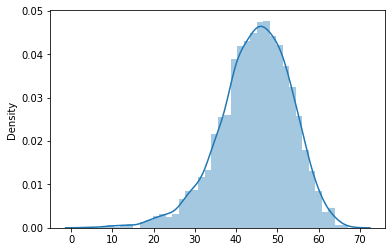

In [16]:
sns.distplot(train['t'][train['e']==1])

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

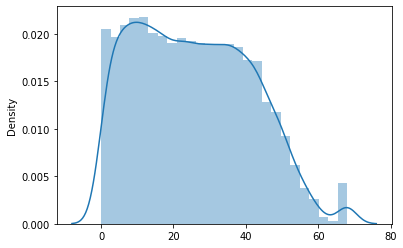

In [17]:
sns.distplot(train['t'][train['e']==0])

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

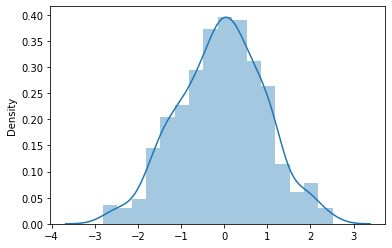

In [15]:
for i, (x, y, e) in enumerate(pair1):
    break
x, y = x.to(device).float(), y.to(device).squeeze().float()
sns.distplot(x[:,0])

epoch1
====> Train NLL: 1.6859 	 Valid NLL loss: 1.7035 	Improved: *
epoch2
====> Train NLL: 1.6649 	 Valid NLL loss: 1.6804 	Improved: *
epoch3
====> Train NLL: 1.6382 	 Valid NLL loss: 1.6486 	Improved: *
epoch4
====> Train NLL: 1.5999 	 Valid NLL loss: 1.6020 	Improved: *
epoch5
====> Train NLL: 1.5453 	 Valid NLL loss: 1.5378 	Improved: *
epoch6
====> Train NLL: 1.4744 	 Valid NLL loss: 1.4616 	Improved: *
epoch7
====> Train NLL: 1.3994 	 Valid NLL loss: 1.3902 	Improved: *
epoch8
====> Train NLL: 1.3367 	 Valid NLL loss: 1.3349 	Improved: *
epoch9
====> Train NLL: 1.2910 	 Valid NLL loss: 1.2950 	Improved: *
epoch10


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


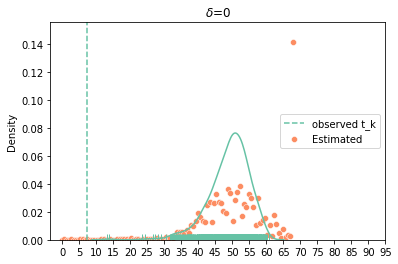

====> Train NLL: 1.2575 	 Valid NLL loss: 1.2665 	Improved: *
epoch11
====> Train NLL: 1.2333 	 Valid NLL loss: 1.2441 	Improved: *
epoch12
====> Train NLL: 1.2138 	 Valid NLL loss: 1.2262 	Improved: *
epoch13
====> Train NLL: 1.1979 	 Valid NLL loss: 1.2121 	Improved: *
epoch14
====> Train NLL: 1.1837 	 Valid NLL loss: 1.1986 	Improved: *
epoch15
====> Train NLL: 1.1708 	 Valid NLL loss: 1.1867 	Improved: *
epoch16
====> Train NLL: 1.1594 	 Valid NLL loss: 1.1771 	Improved: *
epoch17
====> Train NLL: 1.1495 	 Valid NLL loss: 1.1679 	Improved: *
epoch18
====> Train NLL: 1.1418 	 Valid NLL loss: 1.1613 	Improved: *
epoch19
====> Train NLL: 1.1348 	 Valid NLL loss: 1.1560 	Improved: *
epoch20


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


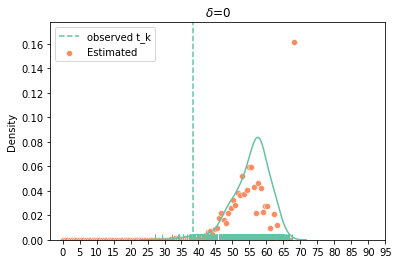

====> Train NLL: 1.1294 	 Valid NLL loss: 1.1516 	Improved: *
epoch21
====> Train NLL: 1.1251 	 Valid NLL loss: 1.1476 	Improved: *
epoch22
====> Train NLL: 1.1213 	 Valid NLL loss: 1.1447 	Improved: *
epoch23
====> Train NLL: 1.1181 	 Valid NLL loss: 1.1418 	Improved: *
epoch24
====> Train NLL: 1.1153 	 Valid NLL loss: 1.1398 	Improved: *
epoch25
====> Train NLL: 1.1133 	 Valid NLL loss: 1.1383 	Improved: *
epoch26
====> Train NLL: 1.1108 	 Valid NLL loss: 1.1361 	Improved: *
epoch27
====> Train NLL: 1.1095 	 Valid NLL loss: 1.1348 	Improved: *
epoch28
====> Train NLL: 1.1072 	 Valid NLL loss: 1.1334 	Improved: *
epoch29
====> Train NLL: 1.1059 	 Valid NLL loss: 1.1320 	Improved: *
epoch30


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


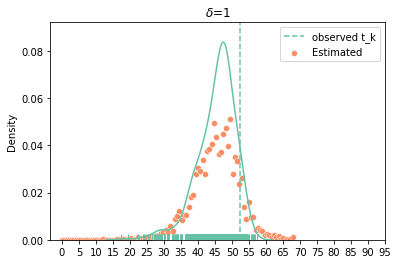

====> Train NLL: 1.1046 	 Valid NLL loss: 1.1312 	Improved: *
epoch31
====> Train NLL: 1.1033 	 Valid NLL loss: 1.1306 	Improved: *
epoch32
====> Train NLL: 1.1022 	 Valid NLL loss: 1.1293 	Improved: *
epoch33
====> Train NLL: 1.1013 	 Valid NLL loss: 1.1286 	Improved: *
epoch34
====> Train NLL: 1.1004 	 Valid NLL loss: 1.1285 	Improved: *
epoch35
====> Train NLL: 1.0997 	 Valid NLL loss: 1.1275 	Improved: *
epoch36
====> Train NLL: 1.0992 	 Valid NLL loss: 1.1268 	Improved: *
epoch37
====> Train NLL: 1.0981 	 Valid NLL loss: 1.1263 	Improved: *
epoch38
====> Train NLL: 1.0976 	 Valid NLL loss: 1.1259 	Improved: *
epoch39
====> Train NLL: 1.0969 	 Valid NLL loss: 1.1253 	Improved: *
epoch40


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


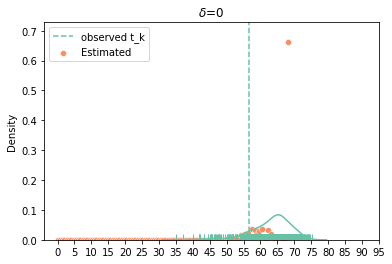

====> Train NLL: 1.0965 	 Valid NLL loss: 1.1247 	Improved: *
epoch41
====> Train NLL: 1.0958 	 Valid NLL loss: 1.1243 	Improved: *
epoch42
====> Train NLL: 1.0954 	 Valid NLL loss: 1.1237 	Improved: *
epoch43
====> Train NLL: 1.0946 	 Valid NLL loss: 1.1234 	Improved: *
epoch44
====> Train NLL: 1.0941 	 Valid NLL loss: 1.1235 	Improved:  
epoch45
====> Train NLL: 1.0936 	 Valid NLL loss: 1.1227 	Improved: *
epoch46
====> Train NLL: 1.0935 	 Valid NLL loss: 1.1225 	Improved: *
epoch47
====> Train NLL: 1.0932 	 Valid NLL loss: 1.1221 	Improved: *
epoch48
====> Train NLL: 1.0926 	 Valid NLL loss: 1.1221 	Improved:  
epoch49
====> Train NLL: 1.0925 	 Valid NLL loss: 1.1220 	Improved: *
epoch50


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


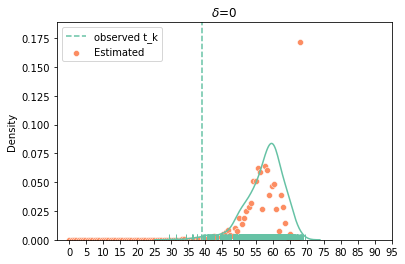

====> Train NLL: 1.0919 	 Valid NLL loss: 1.1214 	Improved: *
epoch51
====> Train NLL: 1.0915 	 Valid NLL loss: 1.1217 	Improved:  
epoch52
====> Train NLL: 1.0915 	 Valid NLL loss: 1.1212 	Improved: *
epoch53
====> Train NLL: 1.0911 	 Valid NLL loss: 1.1210 	Improved: *
epoch54
====> Train NLL: 1.0907 	 Valid NLL loss: 1.1208 	Improved: *
epoch55
====> Train NLL: 1.0907 	 Valid NLL loss: 1.1207 	Improved: *
epoch56
====> Train NLL: 1.0903 	 Valid NLL loss: 1.1204 	Improved: *
epoch57
====> Train NLL: 1.0900 	 Valid NLL loss: 1.1208 	Improved:  
epoch58
====> Train NLL: 1.0896 	 Valid NLL loss: 1.1202 	Improved: *
epoch59
====> Train NLL: 1.0897 	 Valid NLL loss: 1.1202 	Improved: *
epoch60


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


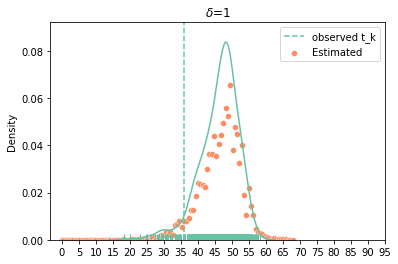

====> Train NLL: 1.0894 	 Valid NLL loss: 1.1201 	Improved: *
epoch61
====> Train NLL: 1.0892 	 Valid NLL loss: 1.1203 	Improved:  
epoch62
====> Train NLL: 1.0890 	 Valid NLL loss: 1.1197 	Improved: *
epoch63
====> Train NLL: 1.0889 	 Valid NLL loss: 1.1198 	Improved:  
epoch64
====> Train NLL: 1.0884 	 Valid NLL loss: 1.1193 	Improved: *
epoch65
====> Train NLL: 1.0886 	 Valid NLL loss: 1.1198 	Improved:  
epoch66
====> Train NLL: 1.0882 	 Valid NLL loss: 1.1192 	Improved: *
epoch67
====> Train NLL: 1.0882 	 Valid NLL loss: 1.1196 	Improved:  
epoch68
====> Train NLL: 1.0881 	 Valid NLL loss: 1.1195 	Improved:  
epoch69
====> Train NLL: 1.0879 	 Valid NLL loss: 1.1189 	Improved: *
epoch70


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


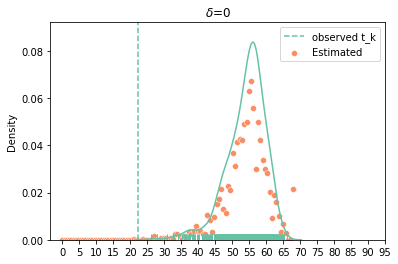

====> Train NLL: 1.0878 	 Valid NLL loss: 1.1194 	Improved:  
epoch71
====> Train NLL: 1.0874 	 Valid NLL loss: 1.1199 	Improved:  
epoch72
====> Train NLL: 1.0875 	 Valid NLL loss: 1.1186 	Improved: *
epoch73
====> Train NLL: 1.0872 	 Valid NLL loss: 1.1193 	Improved:  
epoch74
====> Train NLL: 1.0876 	 Valid NLL loss: 1.1187 	Improved:  
epoch75
====> Train NLL: 1.0869 	 Valid NLL loss: 1.1189 	Improved:  
epoch76
====> Train NLL: 1.0869 	 Valid NLL loss: 1.1187 	Improved:  
epoch77
====> Train NLL: 1.0868 	 Valid NLL loss: 1.1189 	Improved:  
epoch78
====> Train NLL: 1.0867 	 Valid NLL loss: 1.1185 	Improved: *
epoch79
====> Train NLL: 1.0868 	 Valid NLL loss: 1.1183 	Improved: *
epoch80


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


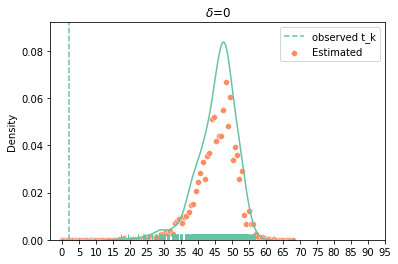

====> Train NLL: 1.0867 	 Valid NLL loss: 1.1187 	Improved:  
epoch81
====> Train NLL: 1.0862 	 Valid NLL loss: 1.1188 	Improved:  
epoch82
====> Train NLL: 1.0862 	 Valid NLL loss: 1.1187 	Improved:  
epoch83
====> Train NLL: 1.0861 	 Valid NLL loss: 1.1187 	Improved:  
epoch84
====> Train NLL: 1.0863 	 Valid NLL loss: 1.1187 	Improved:  
epoch85
====> Train NLL: 1.0862 	 Valid NLL loss: 1.1184 	Improved:  
epoch86
====> Train NLL: 1.0857 	 Valid NLL loss: 1.1183 	Improved:  
epoch87
====> Train NLL: 1.0858 	 Valid NLL loss: 1.1184 	Improved:  
epoch88
====> Train NLL: 1.0856 	 Valid NLL loss: 1.1184 	Improved:  
epoch89
====> Train NLL: 1.0854 	 Valid NLL loss: 1.1178 	Improved: *
epoch90


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


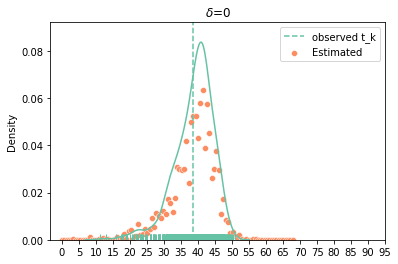

====> Train NLL: 1.0853 	 Valid NLL loss: 1.1180 	Improved:  
epoch91
====> Train NLL: 1.0855 	 Valid NLL loss: 1.1182 	Improved:  
epoch92
====> Train NLL: 1.0853 	 Valid NLL loss: 1.1187 	Improved:  
epoch93
====> Train NLL: 1.0854 	 Valid NLL loss: 1.1180 	Improved:  
epoch94
====> Train NLL: 1.0850 	 Valid NLL loss: 1.1182 	Improved:  
epoch95
====> Train NLL: 1.0850 	 Valid NLL loss: 1.1182 	Improved:  
epoch96
====> Train NLL: 1.0853 	 Valid NLL loss: 1.1182 	Improved:  
epoch97
====> Train NLL: 1.0847 	 Valid NLL loss: 1.1178 	Improved:  
epoch98
====> Train NLL: 1.0846 	 Valid NLL loss: 1.1181 	Improved:  
epoch99
====> Train NLL: 1.0846 	 Valid NLL loss: 1.1179 	Improved:  
epoch100


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


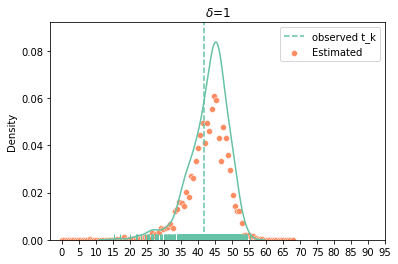

====> Train NLL: 1.0847 	 Valid NLL loss: 1.1183 	Improved:  
epoch101
====> Train NLL: 1.0844 	 Valid NLL loss: 1.1182 	Improved:  
epoch102
====> Train NLL: 1.0846 	 Valid NLL loss: 1.1185 	Improved:  
epoch103
====> Train NLL: 1.0843 	 Valid NLL loss: 1.1177 	Improved: *
epoch104
====> Train NLL: 1.0844 	 Valid NLL loss: 1.1186 	Improved:  
epoch105
====> Train NLL: 1.0844 	 Valid NLL loss: 1.1182 	Improved:  
epoch106
====> Train NLL: 1.0841 	 Valid NLL loss: 1.1180 	Improved:  
epoch107
====> Train NLL: 1.0840 	 Valid NLL loss: 1.1173 	Improved: *
epoch108
====> Train NLL: 1.0839 	 Valid NLL loss: 1.1177 	Improved:  
epoch109
====> Train NLL: 1.0840 	 Valid NLL loss: 1.1177 	Improved:  
epoch110


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


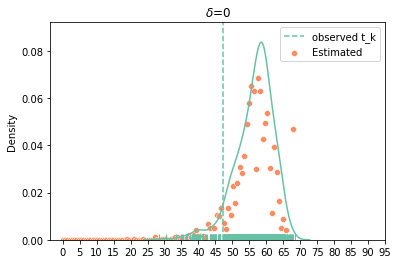

====> Train NLL: 1.0839 	 Valid NLL loss: 1.1184 	Improved:  
epoch111
====> Train NLL: 1.0839 	 Valid NLL loss: 1.1174 	Improved:  
epoch112
====> Train NLL: 1.0837 	 Valid NLL loss: 1.1177 	Improved:  
epoch113
====> Train NLL: 1.0836 	 Valid NLL loss: 1.1172 	Improved: *
epoch114
====> Train NLL: 1.0833 	 Valid NLL loss: 1.1179 	Improved:  
epoch115
====> Train NLL: 1.0836 	 Valid NLL loss: 1.1179 	Improved:  
epoch116
====> Train NLL: 1.0836 	 Valid NLL loss: 1.1178 	Improved:  
epoch117
====> Train NLL: 1.0832 	 Valid NLL loss: 1.1176 	Improved:  
epoch118
====> Train NLL: 1.0834 	 Valid NLL loss: 1.1177 	Improved:  
epoch119
====> Train NLL: 1.0832 	 Valid NLL loss: 1.1179 	Improved:  
epoch120


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


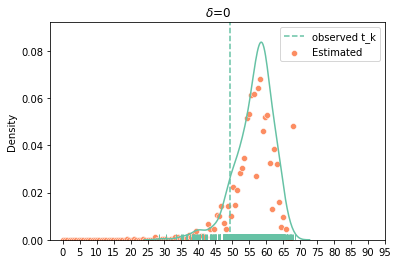

====> Train NLL: 1.0832 	 Valid NLL loss: 1.1176 	Improved:  
epoch121
====> Train NLL: 1.0834 	 Valid NLL loss: 1.1174 	Improved:  
epoch122
====> Train NLL: 1.0834 	 Valid NLL loss: 1.1177 	Improved:  
epoch123
====> Train NLL: 1.0830 	 Valid NLL loss: 1.1177 	Improved:  
epoch124
====> Train NLL: 1.0828 	 Valid NLL loss: 1.1174 	Improved:  
epoch125
====> Train NLL: 1.0829 	 Valid NLL loss: 1.1177 	Improved:  
epoch126
====> Train NLL: 1.0829 	 Valid NLL loss: 1.1171 	Improved: *
epoch127
====> Train NLL: 1.0826 	 Valid NLL loss: 1.1174 	Improved:  
epoch128
====> Train NLL: 1.0827 	 Valid NLL loss: 1.1177 	Improved:  
epoch129
====> Train NLL: 1.0827 	 Valid NLL loss: 1.1177 	Improved:  
epoch130


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


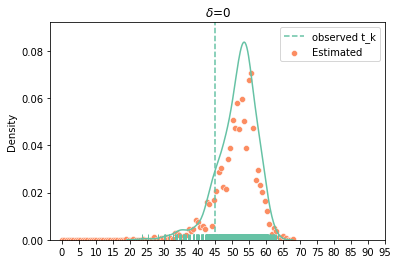

====> Train NLL: 1.0828 	 Valid NLL loss: 1.1175 	Improved:  
epoch131
====> Train NLL: 1.0825 	 Valid NLL loss: 1.1176 	Improved:  
epoch132
====> Train NLL: 1.0826 	 Valid NLL loss: 1.1174 	Improved:  
epoch133
====> Train NLL: 1.0827 	 Valid NLL loss: 1.1180 	Improved:  
epoch134
====> Train NLL: 1.0828 	 Valid NLL loss: 1.1169 	Improved: *
epoch135
====> Train NLL: 1.0825 	 Valid NLL loss: 1.1174 	Improved:  
epoch136
====> Train NLL: 1.0824 	 Valid NLL loss: 1.1180 	Improved:  
epoch137
====> Train NLL: 1.0826 	 Valid NLL loss: 1.1175 	Improved:  
epoch138
====> Train NLL: 1.0822 	 Valid NLL loss: 1.1178 	Improved:  
epoch139
====> Train NLL: 1.0821 	 Valid NLL loss: 1.1172 	Improved:  
epoch140


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


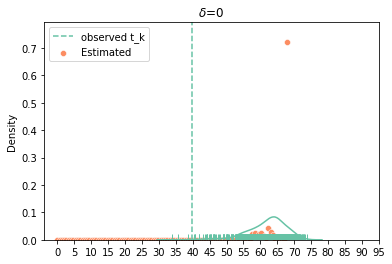

====> Train NLL: 1.0822 	 Valid NLL loss: 1.1172 	Improved:  
epoch141
====> Train NLL: 1.0822 	 Valid NLL loss: 1.1172 	Improved:  
epoch142
====> Train NLL: 1.0821 	 Valid NLL loss: 1.1175 	Improved:  
epoch143
====> Train NLL: 1.0822 	 Valid NLL loss: 1.1178 	Improved:  
epoch144
====> Train NLL: 1.0818 	 Valid NLL loss: 1.1177 	Improved:  
epoch145
====> Train NLL: 1.0818 	 Valid NLL loss: 1.1171 	Improved:  
epoch146
====> Train NLL: 1.0818 	 Valid NLL loss: 1.1176 	Improved:  
epoch147
====> Train NLL: 1.0818 	 Valid NLL loss: 1.1174 	Improved:  
epoch148
====> Train NLL: 1.0817 	 Valid NLL loss: 1.1173 	Improved:  
epoch149
====> Train NLL: 1.0817 	 Valid NLL loss: 1.1175 	Improved:  
epoch150


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


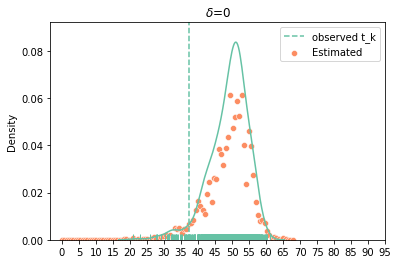

====> Train NLL: 1.0818 	 Valid NLL loss: 1.1174 	Improved:  
epoch151
====> Train NLL: 1.0815 	 Valid NLL loss: 1.1168 	Improved: *
epoch152
====> Train NLL: 1.0812 	 Valid NLL loss: 1.1177 	Improved:  
epoch153
====> Train NLL: 1.0812 	 Valid NLL loss: 1.1177 	Improved:  
epoch154
====> Train NLL: 1.0811 	 Valid NLL loss: 1.1172 	Improved:  
epoch155
====> Train NLL: 1.0813 	 Valid NLL loss: 1.1174 	Improved:  
epoch156
====> Train NLL: 1.0811 	 Valid NLL loss: 1.1177 	Improved:  
epoch157
====> Train NLL: 1.0814 	 Valid NLL loss: 1.1174 	Improved:  
epoch158
====> Train NLL: 1.0809 	 Valid NLL loss: 1.1176 	Improved:  
epoch159
====> Train NLL: 1.0813 	 Valid NLL loss: 1.1174 	Improved:  
epoch160


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


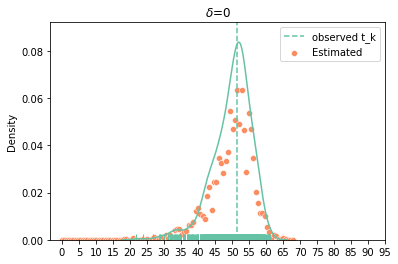

====> Train NLL: 1.0809 	 Valid NLL loss: 1.1173 	Improved:  
epoch161
====> Train NLL: 1.0810 	 Valid NLL loss: 1.1171 	Improved:  
epoch162
====> Train NLL: 1.0812 	 Valid NLL loss: 1.1176 	Improved:  
epoch163
====> Train NLL: 1.0810 	 Valid NLL loss: 1.1171 	Improved:  
epoch164
====> Train NLL: 1.0810 	 Valid NLL loss: 1.1174 	Improved:  
epoch165
====> Train NLL: 1.0809 	 Valid NLL loss: 1.1172 	Improved:  
epoch166
====> Train NLL: 1.0809 	 Valid NLL loss: 1.1175 	Improved:  
epoch167
====> Train NLL: 1.0809 	 Valid NLL loss: 1.1172 	Improved:  
epoch168
====> Train NLL: 1.0810 	 Valid NLL loss: 1.1170 	Improved:  
epoch169
====> Train NLL: 1.0807 	 Valid NLL loss: 1.1177 	Improved:  
epoch170


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


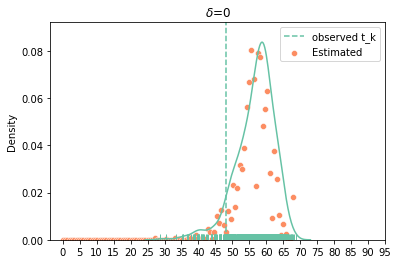

====> Train NLL: 1.0807 	 Valid NLL loss: 1.1171 	Improved:  
epoch171
====> Train NLL: 1.0806 	 Valid NLL loss: 1.1172 	Improved:  
Model stopped due to early stopping


In [18]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    encoder.train()
    decoder.train()
    for i, (x, y, e) in enumerate(pair1):
        
        x= x.to(device).float()
        
        z = encoder(x)
        p_raw = decoder(z)
        y_cat = batch_t_categorize(y, e, tt)
        
        y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
        
        loss = y_loglikeli
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-3)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-3)

        train_loss += loss.item()
        
        opt_enc.step()  
        opt_dec.step()  
        
    train_loss = train_loss/(i+1)     

    
    encoder.eval()
    decoder.eval()
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        
        z = encoder(x)
        p_raw = decoder(z)
        y_cat = batch_t_categorize(y, e, tt)
        
        y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()

        valid_loss_ = y_loglikeli.item()

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss):
        save_model += 1
        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure()
        plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

        sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
        true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
        sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
        plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()
    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.4f} \t Valid NLL loss: {:.4f} \tImproved: {}'.format(train_loss, valid_loss, improved_str))

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

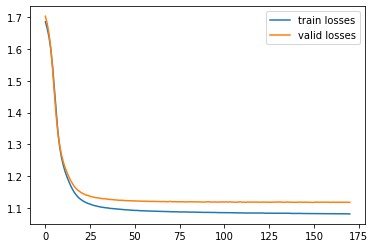

In [19]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [26]:
e.float().mean()


tensor(0.3120)

In [21]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
z = encoder(x.to(device).float())
p_raw = decoder(z)

calculate_KS_Div((x[test['e']==1,:]*std)+mean, p_raw[test['e']==1,:], tt), calculate_KS_Div((x*std)+mean, p_raw, tt)


RuntimeError: Error(s) in loading state_dict for EncMLP:
	size mismatch for net.0.weight: copying a param with shape torch.Size([128, 106]) from checkpoint, the shape in current model is torch.Size([128, 2]).
	size mismatch for net.4.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([2, 128]).
	size mismatch for net.4.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([2]).

In [ ]:
from sksurv.metrics import concordance_index_censored
def get_CI_raw(event, true_t, pred_t):
    return concordance_index_censored((event.squeeze().cpu().detach().numpy()).astype(bool), true_t.squeeze().cpu().detach().numpy(), pred_t.squeeze().cpu().detach().numpy())


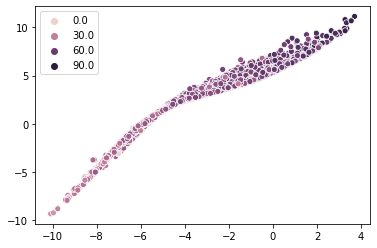

In [756]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [648]:
np.where(test['t']> t_max)

(array([  17,   19,  105,  198,  348,  472,  743,  749,  940, 1009, 1085,
        1180, 1209, 1438, 1504, 1565, 1825, 1951, 2096, 2120, 2251, 2499,
        2555, 2775, 3088, 3090, 3246, 3305, 3338, 3923, 4054, 4202, 4252,
        4298, 4317, 4318, 4357, 4373, 4511, 4626, 4678, 4772, 4970]),)

(tensor(68.), tensor(0))

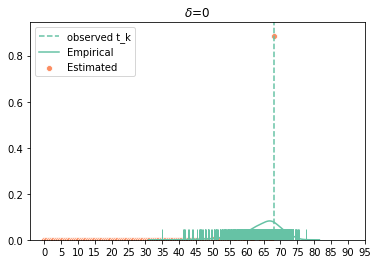

In [650]:
y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
y_cat = batch_t_categorize(y, e, tt)


subj = 105


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]



## select pairs with data loader

In [590]:
for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
    # PAIR 1 need to be non-censored ? +(1-e1)
    # y1 should not equal to y2
    delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
#     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
    x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
    x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]
    
    batch_label = 1*(y1 > y2)
    batch_pair = torch.cat([x1, x2],axis = 1)
    break

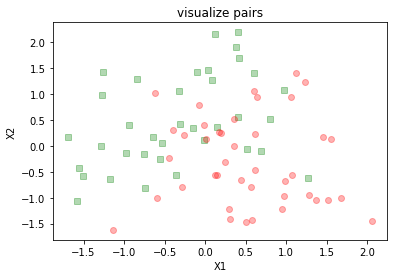

In [591]:
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)
_ = plt.title('visualize pairs')
_ = plt.plot(batch_pair[pos_idx,0].tolist(),batch_pair[pos_idx,ncov].tolist(),'sg',alpha=.3, label='T(X1)>T(X2)')
_ = plt.plot(batch_pair[neg_idx,0].tolist(),batch_pair[neg_idx,ncov].tolist(),'or',alpha=.3, label='T(X1)<T(X2)')

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

## Define the network

In [810]:
# if retrain encoder, decoder
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP(input_size = zdim, output_size = nbin, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)



hidden_layer=[128,128]
epochs = 1000
device = 'cpu'
# input is pair of X
clf = SimpleMLP(input_size = 2*zdim, output_size = 1, h_dim=hidden_layer)

# define optimizer
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# define weight
ctr_wt = 1e-3
clf_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'clf_'+str(ctr_wt)+'.pt'

enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_'+str(ctr_wt)+'.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_'+str(ctr_wt)+'.pt'
print(encoder, decoder)
print(clf)


EncMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=101, bias=True)
  )
  (out): Softmax(dim=1)
)
SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (out): Sigmoid()
)


In [811]:
def single_patient_true_surv_cox_gompertz(covariates, beta_linear = np.array([0.15,0.001]),lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    St = np.exp(-(lambda_/alpha_)*(np.exp(alpha_*tt)-1)*np.exp(np.dot(X,beta_linear)))
    return({"St": St})

# KS divergence
def KS_D(F1, F2, tt):
    diff_list = np.abs((np.ones(len(tt))-F1)-(np.ones(len(tt))-F2))
    return(tt[np.argmax(diff_list)], np.max(diff_list), diff_list)

def calculate_KS_Div(x, p_raw, tt):
    KS_list = []
    for subj in np.arange(p_raw.shape[0]):
        true_St=single_patient_true_surv_cox_gompertz(covariates=x[subj,:].numpy(), tt=tt)['St']
        St = 1-np.cumsum(p_raw[subj,:].detach().numpy())
        diff_t, diff_D, diff_list = KS_D(St, true_St, tt)
        KS_list.append(diff_D)

    return np.mean(KS_list)

epoch1
====> Train Loss: 1.7032 	 NLL: 1.7025 	 contrastive loss: 0.6936
====> Valid NLL loss: 1.7166 	Improved: *
epoch2
====> Train Loss: 1.6779 	 NLL: 1.6772 	 contrastive loss: 0.6923
====> Valid NLL loss: 1.6894 	Improved: *
epoch3
====> Train Loss: 1.6474 	 NLL: 1.6467 	 contrastive loss: 0.6883
====> Valid NLL loss: 1.6528 	Improved: *
epoch4
====> Train Loss: 1.6042 	 NLL: 1.6035 	 contrastive loss: 0.6850
====> Valid NLL loss: 1.6005 	Improved: *
epoch5
====> Train Loss: 1.5446 	 NLL: 1.5439 	 contrastive loss: 0.6817
====> Valid NLL loss: 1.5316 	Improved: *
epoch6
====> Train Loss: 1.4729 	 NLL: 1.4723 	 contrastive loss: 0.6836
====> Valid NLL loss: 1.4572 	Improved: *
epoch7
====> Train Loss: 1.4042 	 NLL: 1.4035 	 contrastive loss: 0.6939
====> Valid NLL loss: 1.3938 	Improved: *
epoch8
====> Train Loss: 1.3500 	 NLL: 1.3493 	 contrastive loss: 0.7110
====> Valid NLL loss: 1.3462 	Improved: *
epoch9
====> Train Loss: 1.3083 	 NLL: 1.3076 	 contrastive loss: 0.7244
====> V

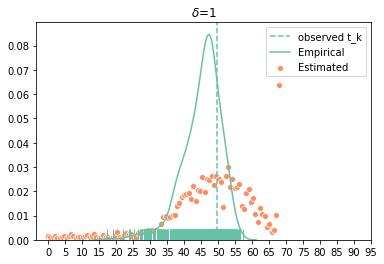

====> Valid NLL loss: 1.2821 	Improved: *
epoch11
====> Train Loss: 1.2528 	 NLL: 1.2522 	 contrastive loss: 0.6728
====> Valid NLL loss: 1.2637 	Improved: *
epoch12
====> Train Loss: 1.2373 	 NLL: 1.2367 	 contrastive loss: 0.6116
====> Valid NLL loss: 1.2515 	Improved: *
epoch13
====> Train Loss: 1.2273 	 NLL: 1.2267 	 contrastive loss: 0.5505
====> Valid NLL loss: 1.2443 	Improved: *
epoch14
====> Train Loss: 1.2208 	 NLL: 1.2203 	 contrastive loss: 0.4956
====> Valid NLL loss: 1.2392 	Improved: *
epoch15
====> Train Loss: 1.2162 	 NLL: 1.2158 	 contrastive loss: 0.4696
====> Valid NLL loss: 1.2358 	Improved: *
epoch16
====> Train Loss: 1.2127 	 NLL: 1.2123 	 contrastive loss: 0.4442
====> Valid NLL loss: 1.2327 	Improved: *
epoch17
====> Train Loss: 1.2096 	 NLL: 1.2092 	 contrastive loss: 0.4401
====> Valid NLL loss: 1.2299 	Improved: *
epoch18
====> Train Loss: 1.2065 	 NLL: 1.2061 	 contrastive loss: 0.4285
====> Valid NLL loss: 1.2273 	Improved: *
epoch19
====> Train Loss: 1.20

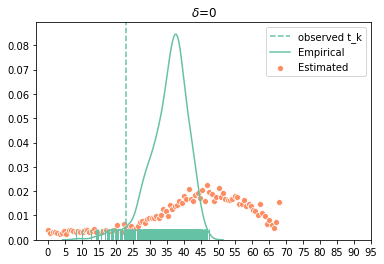

====> Valid NLL loss: 1.2222 	Improved: *
epoch21
====> Train Loss: 1.1966 	 NLL: 1.1962 	 contrastive loss: 0.4383
====> Valid NLL loss: 1.2171 	Improved: *
epoch22
====> Train Loss: 1.1917 	 NLL: 1.1913 	 contrastive loss: 0.4494
====> Valid NLL loss: 1.2119 	Improved: *
epoch23
====> Train Loss: 1.1854 	 NLL: 1.1849 	 contrastive loss: 0.4544
====> Valid NLL loss: 1.2048 	Improved: *
epoch24
====> Train Loss: 1.1769 	 NLL: 1.1764 	 contrastive loss: 0.4339
====> Valid NLL loss: 1.1961 	Improved: *
epoch25
====> Train Loss: 1.1666 	 NLL: 1.1662 	 contrastive loss: 0.4264
====> Valid NLL loss: 1.1860 	Improved: *
epoch26
====> Train Loss: 1.1560 	 NLL: 1.1556 	 contrastive loss: 0.4561
====> Valid NLL loss: 1.1766 	Improved: *
epoch27
====> Train Loss: 1.1464 	 NLL: 1.1460 	 contrastive loss: 0.4569
====> Valid NLL loss: 1.1681 	Improved: *
epoch28
====> Train Loss: 1.1379 	 NLL: 1.1375 	 contrastive loss: 0.4248
====> Valid NLL loss: 1.1615 	Improved: *
epoch29
====> Train Loss: 1.13

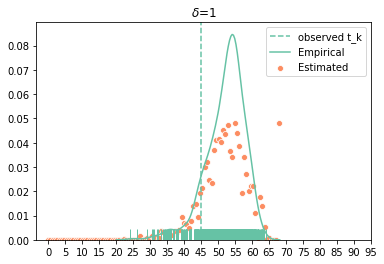

====> Valid NLL loss: 1.1522 	Improved: *
epoch31
====> Train Loss: 1.1223 	 NLL: 1.1219 	 contrastive loss: 0.4237
====> Valid NLL loss: 1.1484 	Improved: *
epoch32
====> Train Loss: 1.1190 	 NLL: 1.1185 	 contrastive loss: 0.4573
====> Valid NLL loss: 1.1453 	Improved: *
epoch33
====> Train Loss: 1.1162 	 NLL: 1.1157 	 contrastive loss: 0.4432
====> Valid NLL loss: 1.1434 	Improved: *
epoch34
====> Train Loss: 1.1139 	 NLL: 1.1135 	 contrastive loss: 0.4474
====> Valid NLL loss: 1.1413 	Improved: *
epoch35
====> Train Loss: 1.1116 	 NLL: 1.1112 	 contrastive loss: 0.4231
====> Valid NLL loss: 1.1398 	Improved: *
epoch36
====> Train Loss: 1.1097 	 NLL: 1.1092 	 contrastive loss: 0.4515
====> Valid NLL loss: 1.1379 	Improved: *
epoch37
====> Train Loss: 1.1080 	 NLL: 1.1076 	 contrastive loss: 0.4221
====> Valid NLL loss: 1.1362 	Improved: *
epoch38
====> Train Loss: 1.1066 	 NLL: 1.1062 	 contrastive loss: 0.4652
====> Valid NLL loss: 1.1358 	Improved: *
epoch39
====> Train Loss: 1.10

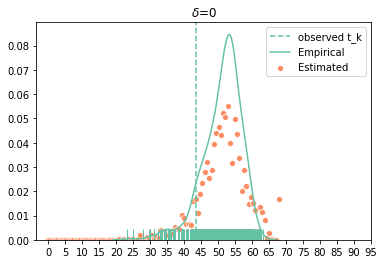

====> Valid NLL loss: 1.1332 	Improved: *
epoch41
====> Train Loss: 1.1032 	 NLL: 1.1027 	 contrastive loss: 0.4586
====> Valid NLL loss: 1.1328 	Improved: *
epoch42
====> Train Loss: 1.1024 	 NLL: 1.1019 	 contrastive loss: 0.4352
====> Valid NLL loss: 1.1323 	Improved: *
epoch43
====> Train Loss: 1.1015 	 NLL: 1.1010 	 contrastive loss: 0.4541
====> Valid NLL loss: 1.1315 	Improved: *
epoch44
====> Train Loss: 1.1004 	 NLL: 1.0999 	 contrastive loss: 0.4452
====> Valid NLL loss: 1.1309 	Improved: *
epoch45
====> Train Loss: 1.0995 	 NLL: 1.0991 	 contrastive loss: 0.4404
====> Valid NLL loss: 1.1305 	Improved: *
epoch46
====> Train Loss: 1.0990 	 NLL: 1.0986 	 contrastive loss: 0.4248
====> Valid NLL loss: 1.1298 	Improved: *
epoch47
====> Train Loss: 1.0980 	 NLL: 1.0975 	 contrastive loss: 0.4592
====> Valid NLL loss: 1.1288 	Improved: *
epoch48
====> Train Loss: 1.0973 	 NLL: 1.0968 	 contrastive loss: 0.4394
====> Valid NLL loss: 1.1294 	Improved:  
epoch49
====> Train Loss: 1.09

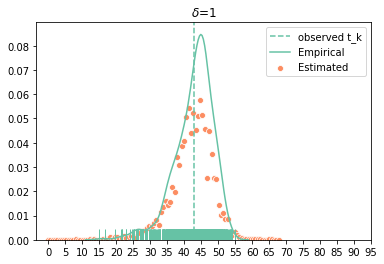

====> Valid NLL loss: 1.1280 	Improved: *
epoch51
====> Train Loss: 1.0957 	 NLL: 1.0953 	 contrastive loss: 0.4441
====> Valid NLL loss: 1.1278 	Improved: *
epoch52
====> Train Loss: 1.0951 	 NLL: 1.0947 	 contrastive loss: 0.3865
====> Valid NLL loss: 1.1275 	Improved: *
epoch53
====> Train Loss: 1.0946 	 NLL: 1.0941 	 contrastive loss: 0.4564
====> Valid NLL loss: 1.1275 	Improved: *
epoch54
====> Train Loss: 1.0942 	 NLL: 1.0938 	 contrastive loss: 0.4313
====> Valid NLL loss: 1.1272 	Improved: *
epoch55
====> Train Loss: 1.0938 	 NLL: 1.0933 	 contrastive loss: 0.4508
====> Valid NLL loss: 1.1271 	Improved: *
epoch56
====> Train Loss: 1.0935 	 NLL: 1.0931 	 contrastive loss: 0.4438
====> Valid NLL loss: 1.1269 	Improved: *
epoch57
====> Train Loss: 1.0930 	 NLL: 1.0926 	 contrastive loss: 0.4615
====> Valid NLL loss: 1.1265 	Improved: *
epoch58
====> Train Loss: 1.0925 	 NLL: 1.0920 	 contrastive loss: 0.4453
====> Valid NLL loss: 1.1271 	Improved:  
epoch59
====> Train Loss: 1.09

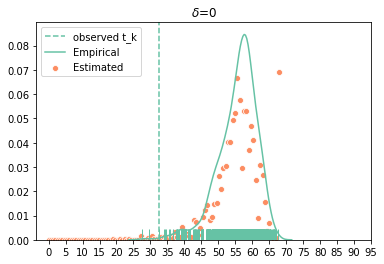

====> Valid NLL loss: 1.1259 	Improved: *
epoch61
====> Train Loss: 1.0916 	 NLL: 1.0911 	 contrastive loss: 0.4403
====> Valid NLL loss: 1.1262 	Improved:  
epoch62
====> Train Loss: 1.0911 	 NLL: 1.0907 	 contrastive loss: 0.4426
====> Valid NLL loss: 1.1262 	Improved:  
epoch63
====> Train Loss: 1.0910 	 NLL: 1.0906 	 contrastive loss: 0.4185
====> Valid NLL loss: 1.1260 	Improved:  
epoch64
====> Train Loss: 1.0907 	 NLL: 1.0902 	 contrastive loss: 0.4517
====> Valid NLL loss: 1.1256 	Improved: *
epoch65
====> Train Loss: 1.0903 	 NLL: 1.0899 	 contrastive loss: 0.4266
====> Valid NLL loss: 1.1257 	Improved:  
epoch66
====> Train Loss: 1.0901 	 NLL: 1.0897 	 contrastive loss: 0.4231
====> Valid NLL loss: 1.1258 	Improved:  
epoch67
====> Train Loss: 1.0900 	 NLL: 1.0895 	 contrastive loss: 0.4418
====> Valid NLL loss: 1.1260 	Improved:  
epoch68
====> Train Loss: 1.0897 	 NLL: 1.0892 	 contrastive loss: 0.4332
====> Valid NLL loss: 1.1253 	Improved: *
epoch69
====> Train Loss: 1.08

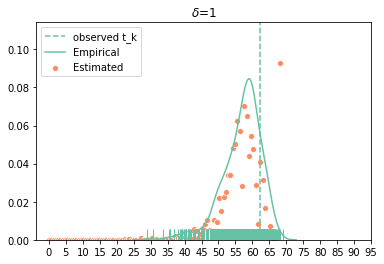

====> Valid NLL loss: 1.1255 	Improved:  
epoch71
====> Train Loss: 1.0889 	 NLL: 1.0885 	 contrastive loss: 0.4523
====> Valid NLL loss: 1.1253 	Improved: *
epoch72
====> Train Loss: 1.0889 	 NLL: 1.0884 	 contrastive loss: 0.4483
====> Valid NLL loss: 1.1251 	Improved: *
epoch73
====> Train Loss: 1.0887 	 NLL: 1.0882 	 contrastive loss: 0.4366
====> Valid NLL loss: 1.1255 	Improved:  
epoch74
====> Train Loss: 1.0884 	 NLL: 1.0880 	 contrastive loss: 0.4438
====> Valid NLL loss: 1.1254 	Improved:  
epoch75
====> Train Loss: 1.0884 	 NLL: 1.0879 	 contrastive loss: 0.4657
====> Valid NLL loss: 1.1253 	Improved:  
epoch76
====> Train Loss: 1.0881 	 NLL: 1.0877 	 contrastive loss: 0.4229
====> Valid NLL loss: 1.1251 	Improved:  
epoch77
====> Train Loss: 1.0880 	 NLL: 1.0876 	 contrastive loss: 0.4346
====> Valid NLL loss: 1.1251 	Improved:  
epoch78
====> Train Loss: 1.0878 	 NLL: 1.0874 	 contrastive loss: 0.4332
====> Valid NLL loss: 1.1259 	Improved:  
epoch79
====> Train Loss: 1.08

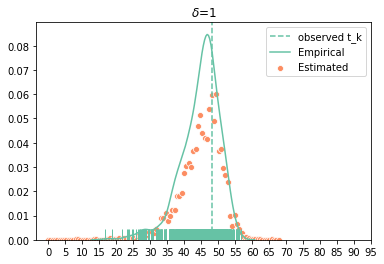

====> Valid NLL loss: 1.1257 	Improved:  
epoch81
====> Train Loss: 1.0872 	 NLL: 1.0867 	 contrastive loss: 0.4479
====> Valid NLL loss: 1.1253 	Improved:  
epoch82
====> Train Loss: 1.0871 	 NLL: 1.0867 	 contrastive loss: 0.4359
====> Valid NLL loss: 1.1248 	Improved: *
epoch83
====> Train Loss: 1.0871 	 NLL: 1.0866 	 contrastive loss: 0.4348
====> Valid NLL loss: 1.1249 	Improved:  
epoch84
====> Train Loss: 1.0868 	 NLL: 1.0864 	 contrastive loss: 0.4203
====> Valid NLL loss: 1.1256 	Improved:  
epoch85
====> Train Loss: 1.0867 	 NLL: 1.0862 	 contrastive loss: 0.4381
====> Valid NLL loss: 1.1252 	Improved:  
epoch86
====> Train Loss: 1.0867 	 NLL: 1.0862 	 contrastive loss: 0.4535
====> Valid NLL loss: 1.1248 	Improved: *
epoch87
====> Train Loss: 1.0863 	 NLL: 1.0859 	 contrastive loss: 0.4197
====> Valid NLL loss: 1.1255 	Improved:  
epoch88
====> Train Loss: 1.0863 	 NLL: 1.0859 	 contrastive loss: 0.4323
====> Valid NLL loss: 1.1252 	Improved:  
epoch89
====> Train Loss: 1.08

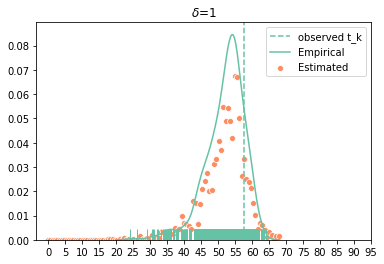

====> Valid NLL loss: 1.1250 	Improved:  
epoch91
====> Train Loss: 1.0860 	 NLL: 1.0855 	 contrastive loss: 0.4467
====> Valid NLL loss: 1.1251 	Improved:  
epoch92
====> Train Loss: 1.0860 	 NLL: 1.0856 	 contrastive loss: 0.4384
====> Valid NLL loss: 1.1253 	Improved:  
epoch93
====> Train Loss: 1.0856 	 NLL: 1.0852 	 contrastive loss: 0.4189
====> Valid NLL loss: 1.1250 	Improved:  
epoch94
====> Train Loss: 1.0855 	 NLL: 1.0851 	 contrastive loss: 0.4356
====> Valid NLL loss: 1.1252 	Improved:  
epoch95
====> Train Loss: 1.0854 	 NLL: 1.0849 	 contrastive loss: 0.4424
====> Valid NLL loss: 1.1251 	Improved:  
epoch96
====> Train Loss: 1.0856 	 NLL: 1.0851 	 contrastive loss: 0.4457
====> Valid NLL loss: 1.1252 	Improved:  
epoch97
====> Train Loss: 1.0852 	 NLL: 1.0848 	 contrastive loss: 0.4261
====> Valid NLL loss: 1.1256 	Improved:  
epoch98
====> Train Loss: 1.0853 	 NLL: 1.0849 	 contrastive loss: 0.4527
====> Valid NLL loss: 1.1253 	Improved:  
epoch99
====> Train Loss: 1.08

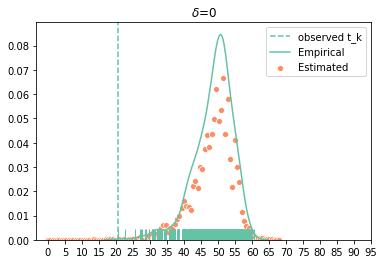

====> Valid NLL loss: 1.1252 	Improved:  
epoch101
====> Train Loss: 1.0850 	 NLL: 1.0846 	 contrastive loss: 0.4344
====> Valid NLL loss: 1.1250 	Improved:  
epoch102
====> Train Loss: 1.0849 	 NLL: 1.0845 	 contrastive loss: 0.4221
====> Valid NLL loss: 1.1249 	Improved:  
epoch103
====> Train Loss: 1.0845 	 NLL: 1.0841 	 contrastive loss: 0.4596
====> Valid NLL loss: 1.1255 	Improved:  
epoch104
====> Train Loss: 1.0845 	 NLL: 1.0840 	 contrastive loss: 0.4396
====> Valid NLL loss: 1.1251 	Improved:  
epoch105
====> Train Loss: 1.0846 	 NLL: 1.0842 	 contrastive loss: 0.4369
====> Valid NLL loss: 1.1249 	Improved:  
epoch106
====> Train Loss: 1.0844 	 NLL: 1.0840 	 contrastive loss: 0.4239
====> Valid NLL loss: 1.1253 	Improved:  
Contrastive learning stopped
epoch107
====> Train Loss: 1.0850 	 NLL: 1.0850 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1248 	Improved:  
epoch108
====> Train Loss: 1.0850 	 NLL: 1.0850 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1248 	Impro

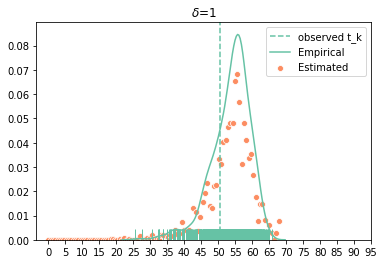

====> Valid NLL loss: 1.1248 	Improved:  
epoch111
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1248 	Improved:  
epoch112
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved: *
epoch113
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved: *
epoch114
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1248 	Improved:  
epoch115
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1248 	Improved:  
epoch116
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch117
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1248 	Improved:  
epoch118
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved: *
epoch119
====> Train L

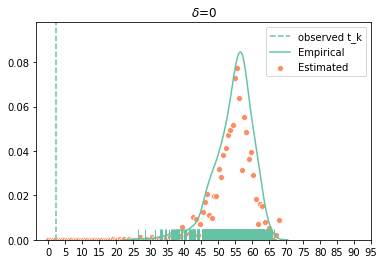

====> Valid NLL loss: 1.1247 	Improved:  
epoch121
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch122
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved: *
epoch123
====> Train Loss: 1.0849 	 NLL: 1.0849 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved: *
epoch124
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch125
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved: *
epoch126
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch127
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch128
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch129
====> Train L

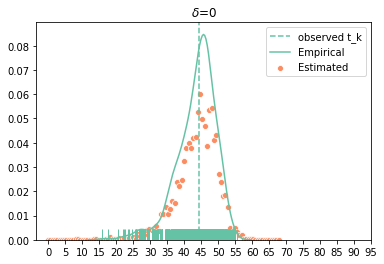

====> Valid NLL loss: 1.1246 	Improved: *
epoch131
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch132
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch133
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch134
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch135
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch136
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch137
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch138
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch139
====> Train L

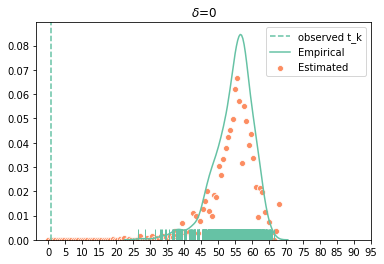

====> Valid NLL loss: 1.1246 	Improved: *
epoch141
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch142
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch143
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch144
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch145
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch146
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch147
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch148
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch149
====> Train L

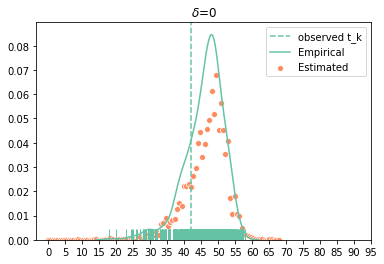

====> Valid NLL loss: 1.1246 	Improved:  
epoch151
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch152
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch153
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch154
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch155
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved: *
epoch156
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch157
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch158
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch159
====> Train L

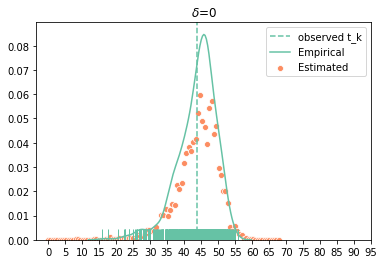

====> Valid NLL loss: 1.1246 	Improved:  
epoch161
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch162
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch163
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch164
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved: *
epoch165
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch166
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch167
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch168
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch169
====> Train L

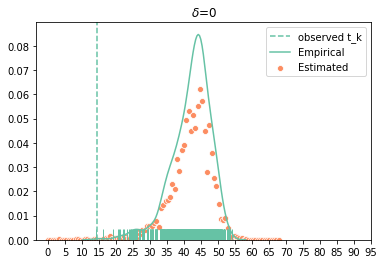

====> Valid NLL loss: 1.1246 	Improved:  
epoch171
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch172
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch173
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch174
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved: *
epoch175
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch176
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch177
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch178
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch179
====> Train L

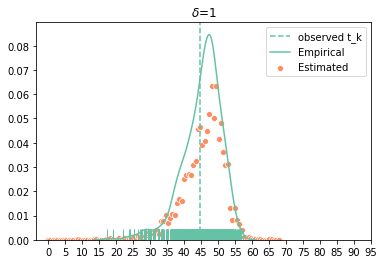

====> Valid NLL loss: 1.1246 	Improved:  
epoch181
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch182
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch183
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch184
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch185
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch186
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch187
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch188
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch189
====> Train L

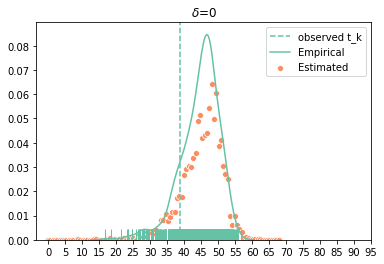

====> Valid NLL loss: 1.1246 	Improved:  
epoch191
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch192
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch193
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch194
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch195
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch196
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch197
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch198
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch199
====> Train L

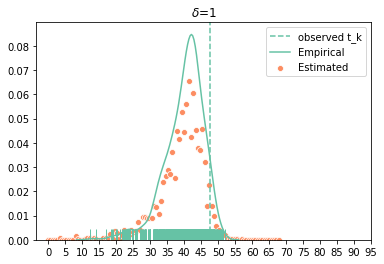

====> Valid NLL loss: 1.1246 	Improved:  
epoch201
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch202
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch203
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch204
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch205
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch206
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch207
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1247 	Improved:  
epoch208
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch209
====> Train L

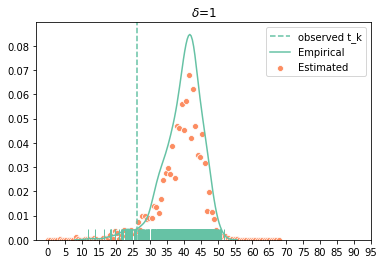

====> Valid NLL loss: 1.1246 	Improved:  
epoch211
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch212
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch213
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved: *
epoch214
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch215
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch216
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch217
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch218
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch219
====> Train L

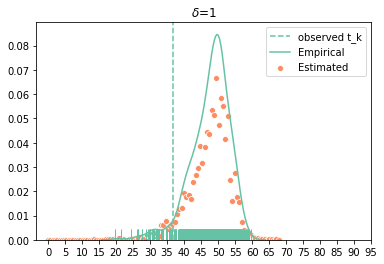

====> Valid NLL loss: 1.1246 	Improved:  
epoch221
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch222
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch223
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch224
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch225
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch226
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch227
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch228
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch229
====> Train L

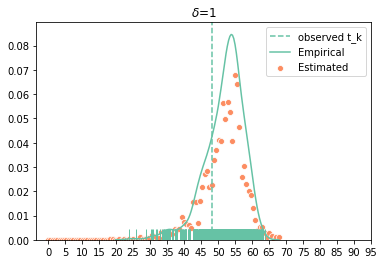

====> Valid NLL loss: 1.1246 	Improved:  
epoch231
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch232
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch233
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch234
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch235
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch236
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch237
====> Train Loss: 1.0848 	 NLL: 1.0848 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved: *
epoch238
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch239
====> Train L

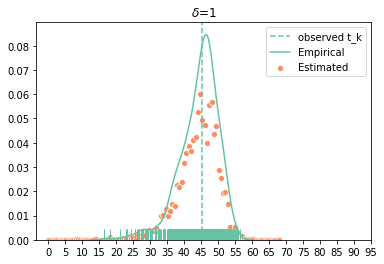

====> Valid NLL loss: 1.1246 	Improved:  
epoch241
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch242
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch243
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch244
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch245
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch246
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch247
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch248
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch249
====> Train L

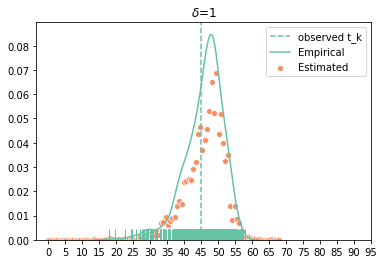

====> Valid NLL loss: 1.1245 	Improved: *
epoch251
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch252
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch253
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch254
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch255
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch256
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch257
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch258
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch259
====> Train L

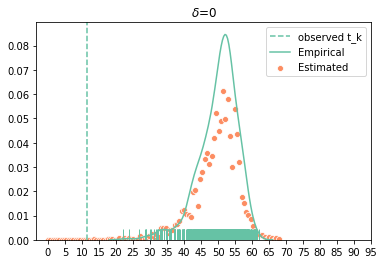

====> Valid NLL loss: 1.1246 	Improved:  
epoch261
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch262
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch263
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch264
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch265
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch266
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch267
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved: *
epoch268
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch269
====> Train L

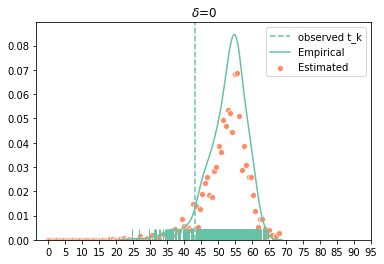

====> Valid NLL loss: 1.1245 	Improved:  
epoch271
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved: *
epoch272
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch273
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch274
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch275
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch276
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch277
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch278
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch279
====> Train L

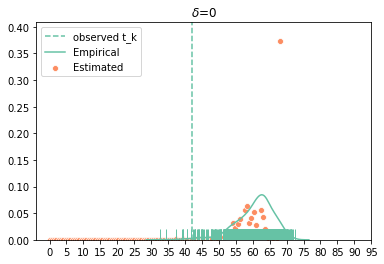

====> Valid NLL loss: 1.1245 	Improved:  
epoch281
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch282
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch283
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch284
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch285
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch286
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch287
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch288
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch289
====> Train L

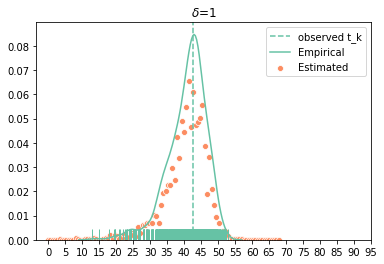

====> Valid NLL loss: 1.1245 	Improved:  
epoch291
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch292
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch293
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch294
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch295
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch296
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch297
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch298
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch299
====> Train L

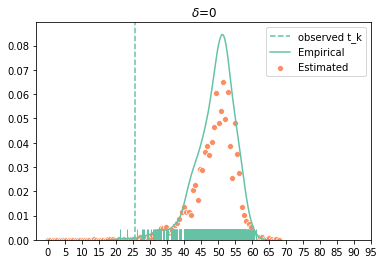

====> Valid NLL loss: 1.1245 	Improved:  
epoch301
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved: *
epoch302
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch303
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch304
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch305
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved: *
epoch306
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch307
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch308
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch309
====> Train L

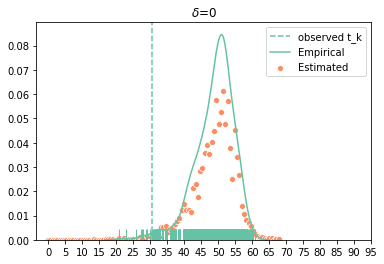

====> Valid NLL loss: 1.1245 	Improved: *
epoch311
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch312
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch313
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch314
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch315
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch316
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch317
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch318
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch319
====> Train L

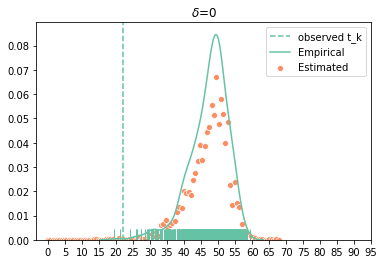

====> Valid NLL loss: 1.1245 	Improved:  
epoch321
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch322
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch323
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch324
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch325
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch326
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch327
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch328
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch329
====> Train L

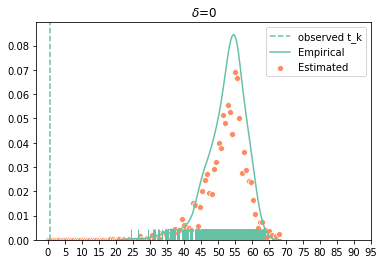

====> Valid NLL loss: 1.1245 	Improved:  
epoch331
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch332
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch333
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch334
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch335
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch336
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch337
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch338
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch339
====> Train L

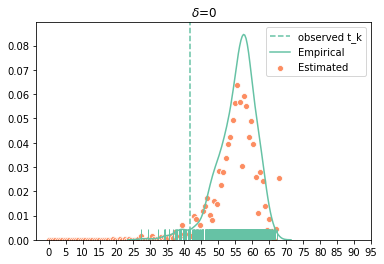

====> Valid NLL loss: 1.1245 	Improved:  
epoch341
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch342
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch343
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch344
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch345
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch346
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch347
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch348
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch349
====> Train L

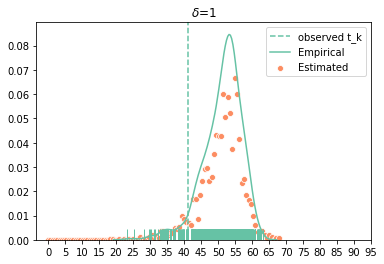

====> Valid NLL loss: 1.1245 	Improved:  
epoch351
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch352
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch353
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1246 	Improved:  
epoch354
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch355
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch356
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch357
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch358
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch359
====> Train L

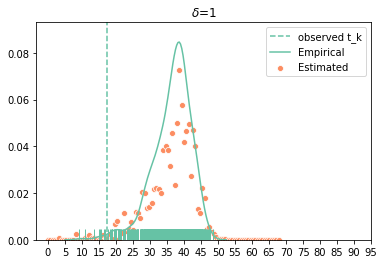

====> Valid NLL loss: 1.1245 	Improved:  
epoch361
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch362
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch363
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch364
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch365
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch366
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch367
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch368
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch369
====> Train L

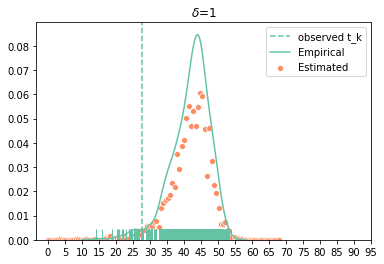

====> Valid NLL loss: 1.1244 	Improved:  
epoch371
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch372
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch373
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch374
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch375
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch376
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch377
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch378
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch379
====> Train L

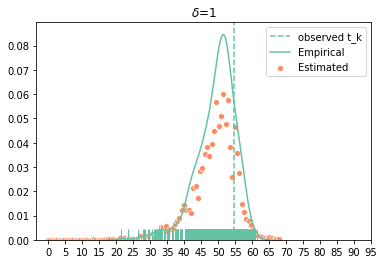

====> Valid NLL loss: 1.1245 	Improved:  
epoch381
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch382
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch383
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch384
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch385
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch386
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch387
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch388
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch389
====> Train L

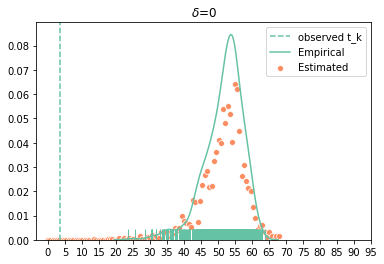

====> Valid NLL loss: 1.1244 	Improved:  
epoch391
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch392
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch393
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch394
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch395
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch396
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch397
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch398
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch399
====> Train L

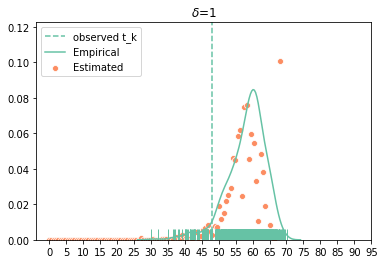

====> Valid NLL loss: 1.1245 	Improved:  
epoch401
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch402
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch403
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch404
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch405
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch406
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved: *
epoch407
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch408
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch409
====> Train L

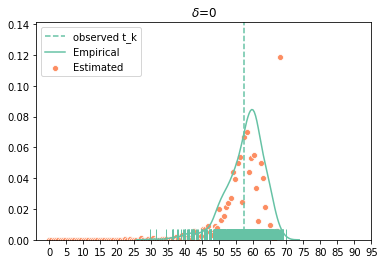

====> Valid NLL loss: 1.1244 	Improved:  
epoch411
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch412
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch413
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch414
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch415
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch416
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch417
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch418
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch419
====> Train L

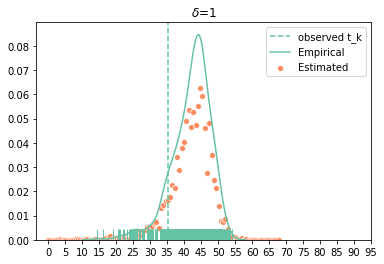

====> Valid NLL loss: 1.1245 	Improved:  
epoch421
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch422
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch423
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch424
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch425
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch426
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch427
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch428
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch429
====> Train L

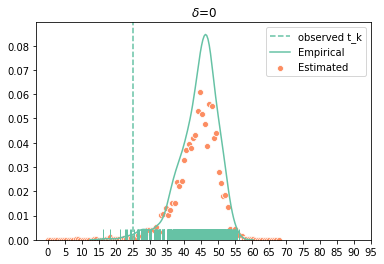

====> Valid NLL loss: 1.1244 	Improved:  
epoch431
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch432
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch433
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch434
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch435
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch436
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch437
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch438
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch439
====> Train L

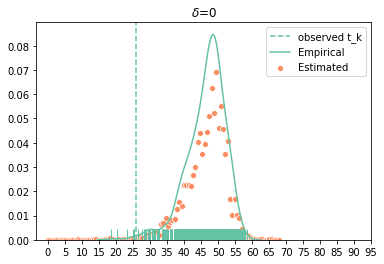

====> Valid NLL loss: 1.1244 	Improved:  
epoch441
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch442
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch443
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch444
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch445
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch446
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch447
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch448
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch449
====> Train L

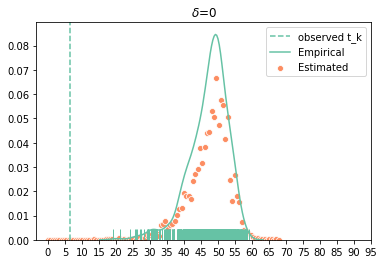

====> Valid NLL loss: 1.1244 	Improved:  
epoch451
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch452
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch453
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch454
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
epoch455
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1245 	Improved:  
epoch456
====> Train Loss: 1.0847 	 NLL: 1.0847 	 contrastive loss: 0.0000
====> Valid NLL loss: 1.1244 	Improved:  
Model stopped due to early stopping


In [812]:
best_valid_loss = np.inf
best_epoch = 0
# encoder.load_state_dict(torch.load(enc_path))
# decoder.load_state_dict(torch.load(dec_path))

train_loss_hist = []
train_rec_hist = []
train_ctr_hist = []

valid_loss_hist = []

ctr_learning = True
for epoch in range(1, epochs + 1):


    train_loss = 0
    rec_loss = 0
    ctr_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "

    
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
#         print(i)
        # training encoder and decoder
        
        x = torch.cat([x1,x2]).to(device).float()
        y = torch.cat([y1,y2])
        e = torch.cat([e1,e2])
                
        if ctr_learning:
            clf.train()
            encoder.train()
            decoder.train()
            z = encoder(x)
            # exclude right censored subjects when training decoder
            p_raw = decoder(z)

            y_cat = batch_t_categorize(y, e, tt)
    #         keep_idx = torch.where(y <= t_max)[0]
            keep_idx = np.arange(len(e))

            y_loglikeli = -((p_raw[keep_idx,:]*torch.tensor(y_cat[keep_idx,:])).sum(axis=1)+1e-6).log().mean()


            # contrastive learning step
            delete_loc = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
            keep_idx_1 = torch.where(delete_loc==0)[0]
            keep_idx_2 = keep_idx_1+len(e1)

            batch_label = (1*(y[keep_idx_1] > y[keep_idx_2])).to(device).squeeze().float()

            batch_pair = torch.cat([z[keep_idx_1], z[keep_idx_2]],axis = 1).to(device).float()

            pred_label = clf(batch_pair)
            BCEloss = torch.nn.BCELoss()
            contrastive_loss = BCEloss(pred_label.squeeze(), batch_label.float())
            
            loss = y_loglikeli + ctr_wt*contrastive_loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-4)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-4)
            torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)

            train_loss += loss.item()
            rec_loss += y_loglikeli.item()
            ctr_loss += contrastive_loss.item()

            opt_enc.step()  
            opt_dec.step()  
            opt_clf.step()          
        else:
            # only train on encoder and decoder
            # or only on decoder
#             encoder.train()
            decoder.train()
            encoder.eval()
            # load the best encoder
            encoder.load_state_dict(torch.load(enc_path))
            decoder.load_state_dict(torch.load(dec_path))

            z = encoder(x)

            # exclude right censored subjects when training decoder
            p_raw = decoder(z)

            y_cat = batch_t_categorize(y, e, tt)
    #         keep_idx = torch.where(y <= t_max)[0]
            keep_idx = np.arange(len(e))

            y_loglikeli = -((p_raw[keep_idx,:]*torch.tensor(y_cat[keep_idx,:])).sum(axis=1)+1e-6).log().mean()
            
            contrastive_loss = torch.tensor([0]).float().to(device)
            
            loss = y_loglikeli
            loss.backward()

#             torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-4)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-4)

            train_loss += loss.item()
            rec_loss += y_loglikeli.item()

#             opt_enc.step()  
            opt_dec.step()  
        
    train_loss = train_loss/(i+1)
    rec_loss = rec_loss/(i+1) 
    ctr_loss = ctr_loss/(i+1)  

    print('====> Train Loss: {:.4f} \t NLL: {:.4f} \t contrastive loss: {:.4f}'.format(train_loss, rec_loss, ctr_loss))
    
    encoder.eval()
    decoder.eval()
    clf.eval()
    
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        
        z = encoder(x)
        p_raw = decoder(z)
        y_cat = batch_t_categorize(y, e, tt)
        
        y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-6).log().mean()

        valid_loss_ = y_loglikeli.item()

        valid_loss += valid_loss_


    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    train_rec_hist.append(rec_loss)
    train_ctr_hist.append(ctr_loss)
    valid_loss_hist.append(valid_loss)
    
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure()

        plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

        sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
        true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
        sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
        plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
                
        plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()

    save_model = 0
    if (best_valid_loss > valid_loss):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid NLL loss: {:.4f} \tImproved: {}'.format(valid_loss, improved_str))

    if ctr_learning and (epoch - best_epoch >=20):
        ctr_learning = False
        print('Contrastive learning stopped')
    
    if not ctr_learning and (epoch - best_epoch >=50):
        print('Model stopped due to early stopping')
        break
        

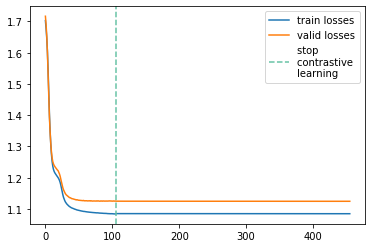

In [813]:
plt.plot(train_rec_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
stop_ctr = train_ctr_hist.index(0)
plt.axvline(stop_ctr,linestyle='--',color=emp_color,label='stop \ncontrastive \nlearning')

plt.legend()

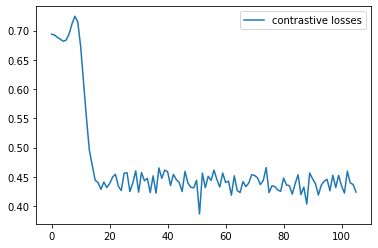

In [817]:
plt.plot(train_ctr_hist[:stop_ctr],label="contrastive losses")
plt.legend()

In [815]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))
for i, (x, y, e) in enumerate(pair1):
    break
enc_path, dec_path

('/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/enc_0.001.pt',
 '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/dec_0.001.pt')

In [818]:
encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
z = encoder(x.to(device).float())
p_raw = decoder(z)
calculate_KS_Div((x[test['e']==1,:]*std)+mean, p_raw[test['e']==1,:], tt), calculate_KS_Div((x*std)+mean, p_raw, tt)

(0.0846867298580055, 0.09748509293069237)

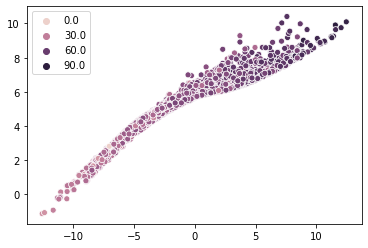

In [819]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [820]:
# torch.where(e==1),
np.where(test['t']>t_max)

(array([  17,   19,  105,  198,  348,  472,  743,  749,  940, 1009, 1085,
        1180, 1209, 1438, 1504, 1565, 1825, 1951, 2096, 2120, 2251, 2499,
        2555, 2775, 3088, 3090, 3246, 3305, 3338, 3923, 4054, 4202, 4252,
        4298, 4317, 4318, 4357, 4373, 4511, 4626, 4678, 4772, 4970]),)

(tensor(68.), tensor(0))

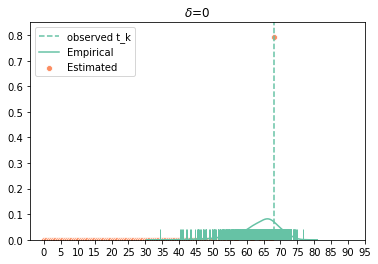

In [825]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
y_cat = batch_t_categorize(y, e, tt)


subj = 4511


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]

# y_cat = batch_t_categorize(y, e, tt)

# subj = 331
# x = x.to(device).float()
# z = encoder(x)
# p_raw = decoder(z)
# plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
# true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
# sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
# plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

# plt.legend(loc='upper right')
# plt.title(r'$\delta$='+str(e[subj].item()))
# y[subj], e[subj]

In [431]:
e.float().mean()

tensor(0.2660)

In [46]:
np.arange(0, 70, step=5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [240]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    clf.train()
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):

        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)
        train_loss += loss.item()
        opt_clf.step()    

    train_loss = train_loss/(i+1)
    
    clf.eval()
    valid_loss = 0
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        valid_loss_ = BCEloss(pred_label.squeeze(), batch_label.float())

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss_):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss_
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid Pair number: {} \tCE loss: {:.4f} \tImproved: {}'.format(len(e1), valid_loss_.item(), improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

epoch1
====> Valid Pair number: 649 	CE loss: 0.8527 	Improved: *
epoch2
====> Valid Pair number: 641 	CE loss: 0.7976 	Improved: *
epoch3
====> Valid Pair number: 653 	CE loss: 0.7649 	Improved: *
epoch4
====> Valid Pair number: 657 	CE loss: 0.6971 	Improved: *
epoch5
====> Valid Pair number: 630 	CE loss: 0.6617 	Improved: *
epoch6
====> Valid Pair number: 632 	CE loss: 0.6347 	Improved: *
epoch7
====> Valid Pair number: 648 	CE loss: 0.6240 	Improved: *
epoch8
====> Valid Pair number: 643 	CE loss: 0.6128 	Improved: *
epoch9
====> Valid Pair number: 658 	CE loss: 0.6176 	Improved:  
epoch10
====> Valid Pair number: 638 	CE loss: 0.5913 	Improved: *
epoch11
====> Valid Pair number: 656 	CE loss: 0.5862 	Improved: *
epoch12
====> Valid Pair number: 621 	CE loss: 0.5889 	Improved:  
epoch13
====> Valid Pair number: 667 	CE loss: 0.5741 	Improved: *
epoch14
====> Valid Pair number: 605 	CE loss: 0.5729 	Improved: *
epoch15
====> Valid Pair number: 643 	CE loss: 0.5616 	Improved: *
epoc

====> Valid Pair number: 664 	CE loss: 0.4939 	Improved:  
epoch124
====> Valid Pair number: 674 	CE loss: 0.4727 	Improved:  
epoch125
====> Valid Pair number: 637 	CE loss: 0.5000 	Improved:  
epoch126
====> Valid Pair number: 648 	CE loss: 0.5156 	Improved:  
epoch127
====> Valid Pair number: 648 	CE loss: 0.4763 	Improved:  
epoch128
====> Valid Pair number: 664 	CE loss: 0.4897 	Improved:  
epoch129
====> Valid Pair number: 626 	CE loss: 0.4832 	Improved:  
epoch130
====> Valid Pair number: 617 	CE loss: 0.4953 	Improved:  
epoch131
====> Valid Pair number: 668 	CE loss: 0.4815 	Improved:  
epoch132
====> Valid Pair number: 661 	CE loss: 0.4700 	Improved:  
epoch133
====> Valid Pair number: 653 	CE loss: 0.5065 	Improved:  
epoch134
====> Valid Pair number: 682 	CE loss: 0.4861 	Improved:  
epoch135
====> Valid Pair number: 640 	CE loss: 0.4857 	Improved:  
epoch136
====> Valid Pair number: 647 	CE loss: 0.4832 	Improved:  
epoch137
====> Valid Pair number: 618 	CE loss: 0.5129 	I

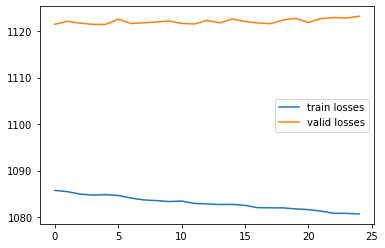

In [396]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [242]:
import pandas as pd


plot_df = pd.DataFrame({'true': batch_label.detach().numpy(), 'pred': pred_label.squeeze().detach().numpy(),\
                        'dataPair1':batch_pair[:,0].detach().numpy(), 'dataPair2':batch_pair[:,1].detach().numpy()})
plot_df.head()

,true,pred,dataPair1,dataPair2
0,1.0,0.744528,25.781141,43.624172
1,1.0,0.744528,15.027925,21.310776
2,1.0,0.744528,20.414146,30.561441
3,1.0,0.744528,22.647816,30.683744
4,0.0,0.742164,15.022316,19.621126


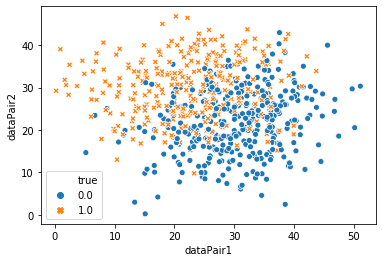

In [243]:
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")


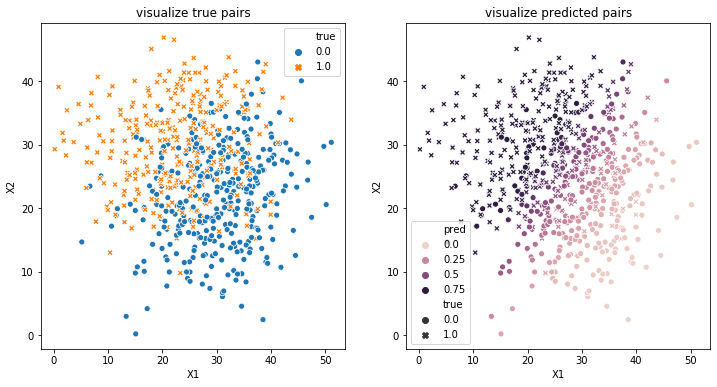

In [244]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)

_ = plt.title('visualize true pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')
plt.subplot(1, 2, 2)



_ = plt.title('visualize predicted pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="pred", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

In [257]:
subj = np.random.sample(np.where(test['e']==1))
subj

TypeError: only integer scalar arrays can be converted to a scalar index

In [258]:
np.where(test['e']==1)

(array([  14,   16,   19, ..., 4992, 4996, 4998]),)

In [288]:
np.where(test['e']==1)
subj = 14

In [422]:
# Restore variables from disk.
clf.load_state_dict(torch.load(clf_path))
print("Model restored.")

# new object to predict g(x_subj)
# on the left
# subj = 2
# on the right
# subj=6
# relatively good 
# subj=8
x_subj = test['x'][subj]     # You can play with this
# x_subj = train['x'][subj]
draw_dataset = test
# Return evenly spaced numbers over a specified interval.
# is tt the we want?
# change tt to percentage scale

tt = np.percentile(train['T'],np.delete(np.linspace(0.,100.,1000, endpoint=False),0))
tt_bin = np.ones(len(tt))
# tt = np.linspace(ST[0]-0.5,ST[-1]+0.5,1000).reshape(1000)
# tt_bin = [y-x for x, y in zip(tt[:-1], tt[1:])]
# tt = np.delete(tt,0)

# SFX sorted original training dataset
x_subj_query = np.concatenate((np.tile(x_subj,[SX.shape[0],1]),SX),axis=1)

prob_subj = clf(torch.tensor(x_subj_query).to(device).float()).squeeze().detach().numpy()

# ST: sorted g(X_train)
# returns a matrix of size(tt)*size(ST)
# each ST corresponding to SFX
TC = compute_concord(tt,ST)

EPS = 1e-10
#aggregate information over bins
# binomial log-likelihood
tau = 0.2
score = np.mean(np.log(prob_subj+EPS)*TC+np.log(1-prob_subj+EPS)*(1-TC),axis=1)
score = score/tau
# normalize based on bin size!
post_prob = (np.exp(score)*tt_bin)/np.sum(np.exp(score)*tt_bin)

# np.save(output_dir+'/'+'M'+str(M0)+'replicate'+str(replicate_number)+"_MLP_post_prob",post_prob)




RuntimeError: Error(s) in loading state_dict for SimpleMLP:
	size mismatch for net.0.weight: copying a param with shape torch.Size([32, 2]) from checkpoint, the shape in current model is torch.Size([32, 4]).

In [2]:
width = 18
height = 6
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)

plt.plot(SX, prob_subj, 'o')
plt.xlabel("sorted training X")
plt.ylabel("classifier output")
plt.axvline(draw_dataset['x'][subj],linestyle='--', label='x_k')
plt.legend()

plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")


# plt.subplot(1,3,2)
# plt.plot(ST, prob_subj, 'o')
# plt.xlabel("training T based on sorted X")
# plt.ylabel("classifier output")
# plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
# plt.legend()
# plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")
# # plt.xlim(50,80)

plt.subplot(1,2,2)
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']

plt.plot(tt, post_prob/0.1, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False,label="Empirical")
plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')


#
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')


plt.legend()
plt.title("Time-to-event distribution, event label:{}".format(test['e'][subj]))

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Time-to-event distribution')

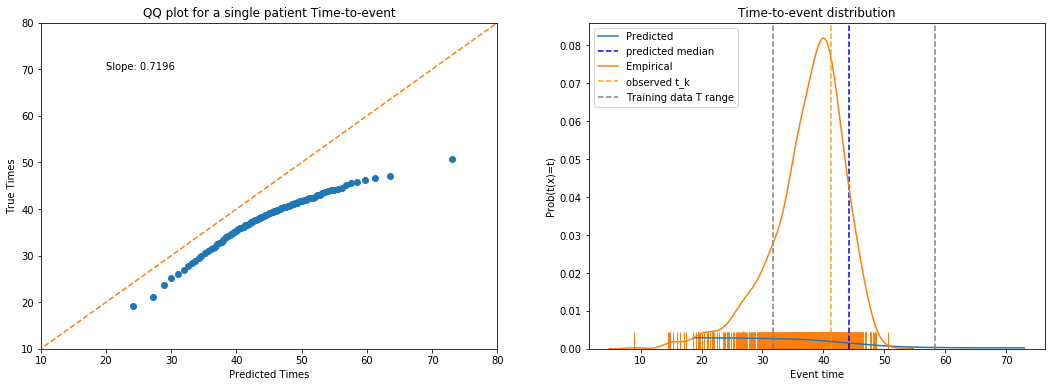

In [282]:
# calculate QQ-plot
import numpy as np
import matplotlib.pyplot as plt


pred_quantiles = calculate_quantiles(post_prob, tt, percentiles=np.linspace(0,1,100))
true_quantiles = np.percentile(true_T,np.linspace(0,100,100))
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pred_quantiles, true_quantiles)

width = 18
height = 6
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.text(20,70, 'Slope: '+str(np.round(slope,4)))
plt.plot(pred_quantiles, true_quantiles, 'o')
plt.plot(np.linspace(0,100,100),np.linspace(0,100,100), linestyle='--')
plt.xlim(10,80)
plt.ylim(10,80)
plt.xlabel('Predicted Times')
plt.ylabel('True Times')
plt.title('QQ plot for a single patient Time-to-event')

plt.subplot(1,2,2)
plt.plot(tt, post_prob, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False, label="Empirical")

plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')

plt.legend()
plt.title("Time-to-event distribution")

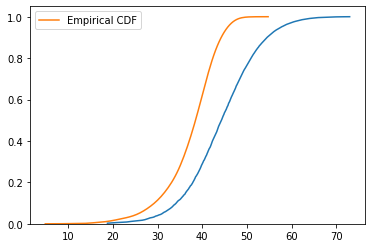

In [283]:
plt.plot(tt,np.cumsum(post_prob))
sns.distplot(true_T, hist=False, label="Empirical CDF", kde_kws=dict(cumulative=True))
